<a href="https://colab.research.google.com/github/siri2511/Speech-Processing/blob/main/PitchAndFormants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

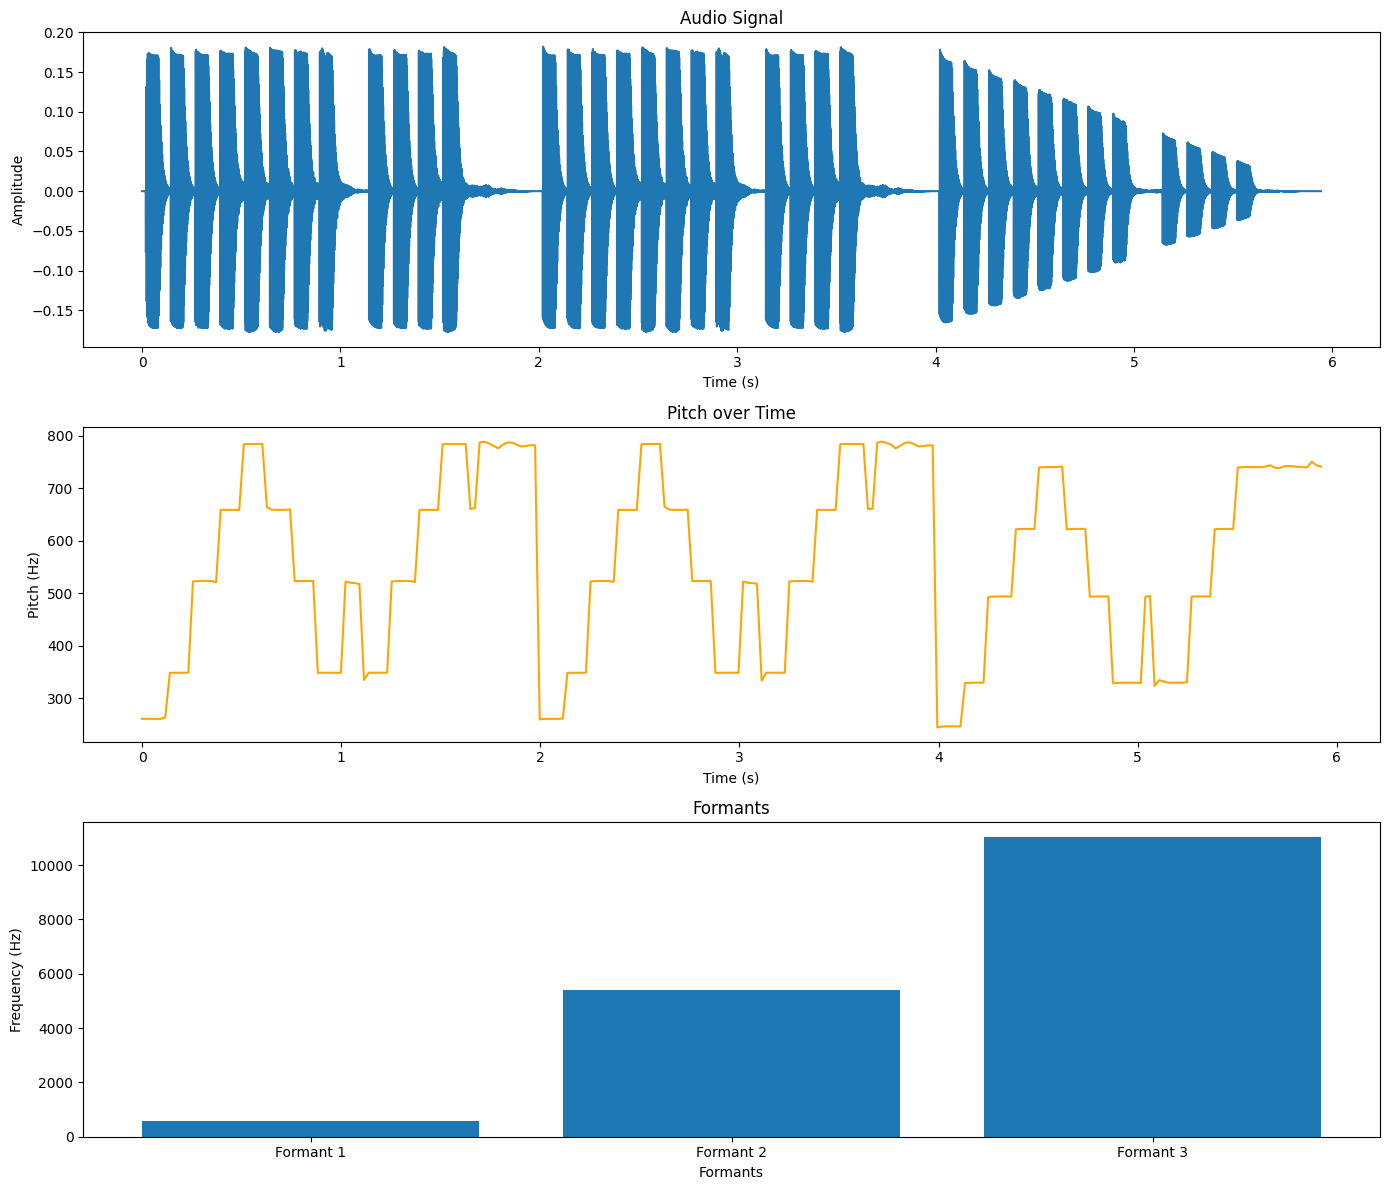

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import soundfile as sf
import librosa

def extract_pitch_and_formants(audio_path, sr=22050):
    try:
        y, sr = librosa.load(audio_path, sr=sr)
    except FileNotFoundError:
        raise FileNotFoundError(f"The file '{audio_path}' was not found. Please check the file path.")
    except Exception as e:
        raise RuntimeError(f"An error occurred while loading the audio file: {e}")

    try:
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
        pitch = np.array([pitches[magnitudes[:, t].argmax(), t] for t in range(magnitudes.shape[1]) if magnitudes[:, t].max() > 0])
        pitch = np.nan_to_num(pitch)  # Replace NaN with zero if needed
        times = librosa.times_like(pitch, sr=sr)
    except Exception as e:
        raise RuntimeError(f"An error occurred while extracting pitch: {e}")

    try:
        def get_formants(y, sr, num_formants=5):
            # Perform LPC to estimate formants
            lpc_coeffs = librosa.lpc(y, order=num_formants + 2)  # Slightly higher order for formants
            roots = np.roots(lpc_coeffs)  # Find the roots of the LPC polynomial
            roots = [r for r in roots if np.imag(r) >= 0]  # Only keep roots with positive imaginary parts
            formants = np.angle(roots) * (sr / (2 * np.pi))  # Convert to frequency
            return sorted(formants[formants > 0])[:num_formants]  # Return only the positive formants

        formants = get_formants(y, sr)
    except Exception as e:
        raise RuntimeError(f"An error occurred while extracting formants: {e}")

    return y, sr, pitch, times, formants

def plot_audio_and_features(audio_path):
    y, sr, pitch, times, formants = extract_pitch_and_formants(audio_path)
    audio_times = np.linspace(0, len(y) / sr, num=len(y))

    plt.figure(figsize=(14, 12))

    # Plot the audio waveform
    plt.subplot(3, 1, 1)
    plt.plot(audio_times, y)
    plt.title("Audio Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Plot the pitch over time
    plt.subplot(3, 1, 2)
    plt.plot(times, pitch, label='Pitch', color='orange')
    plt.title("Pitch over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Pitch (Hz)")

    # Plot the formants
    plt.subplot(3, 1, 3)
    plt.bar(range(len(formants)), formants, tick_label=[f"Formant {i+1}" for i in range(len(formants))])
    plt.title("Formants")
    plt.xlabel("Formants")
    plt.ylabel("Frequency (Hz)")

    plt.tight_layout()
    plt.show()

# Example usage:
audio_path = '/content/example_WAV.wav'
plot_audio_and_features(audio_path)
